In [10]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

# Data Acquisition - Selecting Cryptos of Interest
    1. Get all coin data from coincap.io
    2. Select coins in current portfolio

In [11]:
all_coins_dict = json.loads(BeautifulSoup(
                requests.get('http://coincap.io/front').content, "html.parser").prettify())

#Enter coins of interest
current_coins = ["LTC", "ETH", "BTC", "BCH"]

all_coins_df = pd.DataFrame(all_coins_dict)
coins_by_mcap = all_coins_df[all_coins_df.mktcap > 5e9]

#current_coins = coins_by_mcap['short']
#print("Portfolio coins with MCAP > 5 Billion :\n",current_coins.values)

current_portfolio = all_coins_df[all_coins_df["short"].isin(current_coins)]


# Acquire Data - Get Historical Prices
    1. Get all the price data for a particular coin from coincap.io
    2. Create a master dataframe to hold historical price data for all the selected coins
   

In [12]:
#Create a DataFrame that will hold all the price & data for all the selected coins

combined_df = pd.DataFrame()

#Loop through all the coins in the portfolio & get their historical prices

for coin in current_coins:
    dic_t = json.loads(BeautifulSoup(
            requests.get("http://coincap.io/history/365day/"+coin).
            content, "html.parser").prettify())
    prices = dic_t.get("price")
    coindf = pd.DataFrame.from_records(prices, columns=["time", "price"])
    coindf["coin"] = coin
    combined_df = combined_df.append(coindf, ignore_index=True)


# Data Wrangling
Clean the historical price data, and find returns and covariance

In [13]:
#Change the time formart
combined_df['time'] = pd.to_datetime(combined_df['time'],unit='ms')
combined_df['time'] = [d.date() for d in combined_df['time']]

operational_df = combined_df.groupby(['time', 'coin'],as_index=False)[['price']].mean()
operational_df = operational_df.set_index('time')

pivoted_portfolio = operational_df.pivot(columns='coin')

# get covariance & returns of the coin - daily & for the period 

daily_returns = pivoted_portfolio.pct_change()
period_returns = daily_returns.mean()*365

daily_covariance = daily_returns.cov()
period_covariance = daily_covariance*365


In [14]:
p_returns, p_volatility, p_sharpe_ratio, p_coin_weights=([] for i in range(4))

# portfolio combinations to probe
number_of_cryptoassets = len(current_coins)
number_crypto_portfolios = 70000

# for each portoflio, get returns, risk and weights
for a_crypto_portfolio in range(number_crypto_portfolios):
    weights = np.random.random(number_of_cryptoassets)
    weights /= np.sum(weights)
    
    #print(weights)
    returns = np.dot(weights, period_returns)*100
    
    #print(weights)
    volatility = np.sqrt(np.dot(weights.T, np.dot(period_covariance, weights)))*100
   
    p_sharpe_ratio.append(returns/volatility)
    p_returns.append(returns)
    p_volatility.append(volatility)
    p_coin_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'volatility': p_volatility,
             'sharpe_ratio': p_sharpe_ratio, 'returns': p_returns}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(current_coins):
    portfolio[symbol+'-%'] = [Weight[counter] for Weight in p_coin_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# Visualize Efficient Frontier

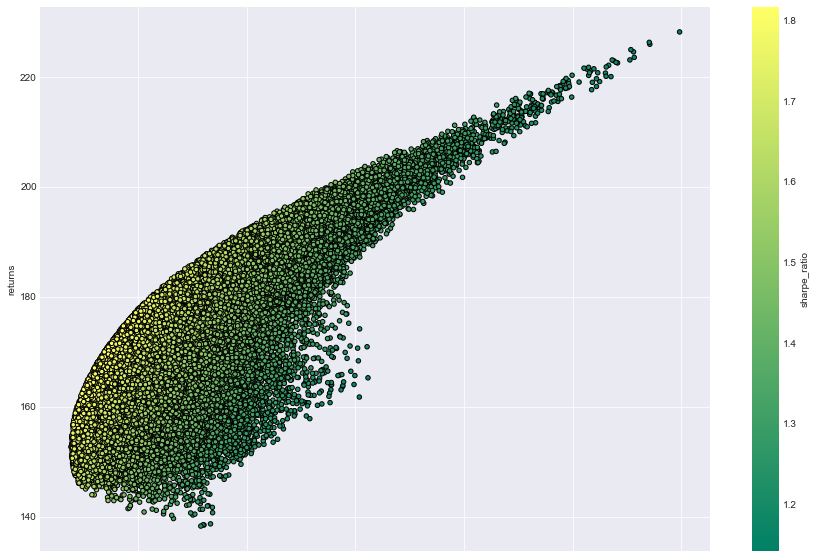

In [15]:
order_cols = ['returns', 'volatility', 'sharpe_ratio']+[coin+'-%' for coin in current_coins]
df = df[order_cols]

sharpe_portfolio = df.loc[df['sharpe_ratio'] == df['sharpe_ratio'].max()]
min_variance_port = df.loc[df['volatility'] == df['volatility'].min()]
max_returns_port = df.loc[df['returns'] == df['returns'].max()]

plt.style.use('seaborn-dark')


df.plot.scatter(x='volatility', y='returns', c='sharpe_ratio', cmap='summer', 
                edgecolors='black', figsize=(15, 10), grid=True)





plt.show()


In [16]:
print('****Portfolio Allocations*****')
print(sharpe_portfolio)


****Portfolio Allocations*****
          returns  volatility  sharpe_ratio     LTC-%     ETH-%     BTC-%  \
37422  167.228561   92.059345       1.81653  0.193782  0.628544  0.149153   

          BCH-%  
37422  0.028521  
